**1.1 Data download and Initialization**

These first few cells install pyro and download the frey faces Dataset
What we need from here is the ```ff``` numpy array that holds all the frey faces with ```shape``` 1965x28x20.

TODO: actually use test split for verification instead of using everything for training
TODO2: HMC not running properly



In [1]:
!pip3 install pyro-ppl 

In [2]:
import torch
import pyro
import pyro.distributions as dist
import torch.distributions.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

torch.manual_seed(101)
pyro.set_rng_seed(101)
np.random.seed(101)

In [3]:
# get frey faces
# download and visualization snippet copied from https://dohmatob.github.io/research/2016/10/22/VAE.html

import os
from urllib.request import urlopen, URLError, HTTPError
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")

    #handle errors
    except (HTTPError, e):
        print("HTTP Error:", e.code, url)
    except (URLError, e):
        print("URL Error:", e.reason, url)
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename)
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file frey_rawface.mat exists.


**1.2 Helper functions**

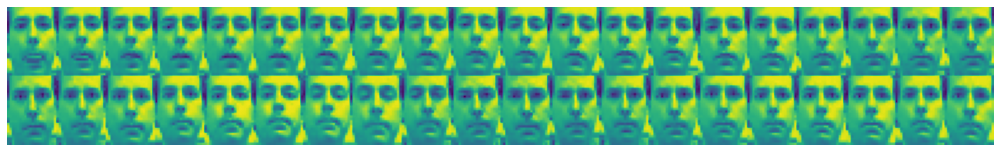

In [4]:
# Draws the pictures for visual inspection
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(14, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=40)

In [5]:
# visualize learned factors
def show_factors(learned_beta, learned_theta):
    print(learned_theta.shape)
    print(learned_beta.shape)

    factors = torch.empty(size=(10, 28, 20))
    for i in range(10):
        factors[i,:,:] = dist.Poisson(torch.ger(torch.transpose(learned_theta, 0, 1)[:,i], learned_beta[i,:])).mean

    factors_np = factors.detach().numpy()
    # show_examples(factors_np + ff.mean(axis=0), 10, 5)
    show_examples(factors_np, 10, 5)

In [6]:
# split data into training and test sets
from torch.utils.data import DataLoader

train_set, test_set = torch.utils.data.random_split(ff, [1572, 393])
train_loader = DataLoader(train_set, batch_size=1572)
test_loader = DataLoader(test_set, batch_size=393)

**2. Model Definition**
The Gamma-Poisson Model is defined here and valid for all approximation/sampling techniques.

In [7]:
def model(data, U = 28, I = 20, K = 10):
    # Draw parameters
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(K)*1000.).expand([U]).to_event(1))
    beta = pyro.sample('beta', dist.Exponential(0.1).expand([K, I]).to_event(2))

    # Generate observations
    with pyro.plate("data", len(data)):
        obs = pyro.sample("obs", dist.Poisson(torch.mm(theta, beta)).to_event(2), obs = data)

**3.1 ADVI**
The ADVI implementation consists of the custom guide and the actual learning.

In [8]:
# GUIDE
def guide(y, U = 28, I = 20, K = 10):
    # theta params
    theta_mu = torch.randn([U,K-1])
    theta_sigma = torch.log(torch.abs(torch.randn([U,K-1])))
    theta_mu_param = pyro.param("theta_mu", theta_mu)
    theta_sigma_param = pyro.param("theta_sigma", theta_sigma)
    pyro.sample("theta", dist.TransformedDistribution(dist.Normal(theta_mu_param, torch.exp(theta_sigma_param)), transforms.StickBreakingTransform()).to_event(1))

    # beta params
    beta_mu = torch.randn([K,I])
    beta_sigma = torch.log(torch.abs(torch.randn([K,I])))
    beta_mu_param = pyro.param("beta_mu", beta_mu)
    beta_sigma_param = pyro.param("beta_sigma", beta_sigma)
    pyro.sample("beta", dist.TransformedDistribution(dist.Normal(beta_mu_param, torch.exp(beta_sigma_param)), transforms.ExpTransform()).to_event(2))

In [9]:
# LEARN
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
pyro.clear_param_store()

step_ids = []
step_time = []
test_log_predictives = []
train_time = 0
for j in range(1000):
    loss = 0

    t0 = time.time()
    for data in train_loader:
        loss += svi.step(data)
    t1 = time.time()
    train_time += (t1-t0)

    if j%100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_loader.dataset)))

    learned_theta_mu = pyro.get_param_store().get_param('theta_mu')
    learned_beta_mu = pyro.get_param_store().get_param('beta_mu')
    poiss_dist = dist.Poisson(torch.mm(transforms.StickBreakingTransform()(learned_theta_mu), torch.exp(learned_beta_mu)))
    test_log_prob = 0
    for data in test_loader:
      test_log_prob += poiss_dist.log_prob(data).sum()

    step_ids.append(j)
    step_time.append(train_time)
    test_log_predictives.append(test_log_prob.detach() / float(len(test_loader.dataset) * 20 * 28))

[iteration 0001] loss: 292633.3000
[iteration 0101] loss: 102972.9030
[iteration 0201] loss: 15791.8311
[iteration 0301] loss: 14819.6677
[iteration 0401] loss: 13787.6293
[iteration 0501] loss: 11056.3050
[iteration 0601] loss: 10206.6386
[iteration 0701] loss: 9931.7469
[iteration 0801] loss: 12196.8771
[iteration 0901] loss: 9141.9892


Text(0, 0.5, 'Average log predictive')

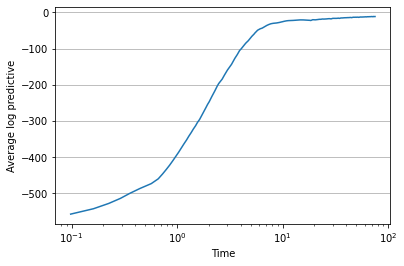

In [15]:
plt.plot(step_time, test_log_predictives)
ax = plt.gca()
ax.grid(axis='y')
plt.xlabel("Time")
plt.xscale("log")
plt.ylabel("Average log predictive")

theta_mu torch.Size([28, 9])
theta_sigma torch.Size([28, 9])
beta_mu torch.Size([10, 20])
beta_sigma torch.Size([10, 20])
torch.Size([10, 28])
torch.Size([10, 20])


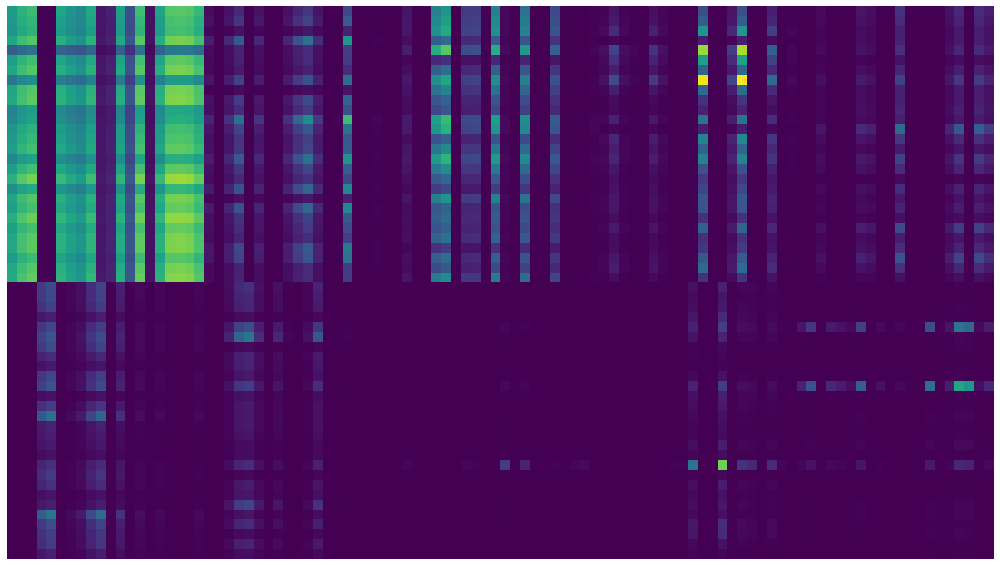

In [11]:
# reconstruct factor pictures
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

learned_theta_mu = pyro.get_param_store().get_param('theta_mu')
learned_beta_mu = pyro.get_param_store().get_param('beta_mu')

show_factors(torch.exp(learned_beta_mu), torch.transpose(transforms.StickBreakingTransform()(learned_theta_mu), 0, 1))

**3.2 NUTS**

Simpler than ADVI, we just use the NUTS sampler and inspect the learned factors.
TODO: log_probs at every step

In [12]:
from pyro.infer import MCMC, NUTS
pyro.clear_param_store()

import pandas as pd
output = pd.DataFrame(columns = ["run_id", "t", "num_samples", "avg_test_log_prob", "model"])

num_runs = 1
max_samples = 200
max_warmups = 200

num_steps = 10

for i in range(num_steps): #range(int(max_samples/50)):
  
  num_samples = int(max_samples * ((i+1)/num_steps))
  num_warmups = int(max_warmups * ((i+1)/num_steps))
  
  print('Num samples: {}'.format(num_samples))

  for run_id in range(num_runs):
    print('---- Run id: {}'.format(run_id))
    nuts_kernel = NUTS(model,
                       max_tree_depth = 4)

    mcmc = MCMC(
            nuts_kernel,
            num_samples=num_samples,
            warmup_steps=num_warmups,
            disable_progbar=False,
            num_chains = 1
    ) 

    start = time.time()
    mcmc.run(torch.tensor(train_set))
    end = time.time()

    samples = mcmc.get_samples()
    learned_theta = samples['theta'].mean(axis=0)
    learned_beta = samples['beta'].mean(axis=0)

    poiss_dist = dist.Poisson(torch.mm(learned_theta, learned_beta))

    test_log_prob = 0
    for data in test_loader:
      test_log_prob += poiss_dist.log_prob(data).sum()

    output_iter = {"run_id":run_id,
                  "t":end-start,
                  "num_samples":num_samples, 
                  "avg_test_log_prob":test_log_prob.detach().numpy() / float(len(test_loader.dataset) * 20 * 28),
                   "model":"nuts"}

    output = output.append(output_iter, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Num samples: 20
---- Run id: 0


Sample: 100%|██████████| 40/40 [00:03, 10.25it/s, step size=6.94e-04, acc. prob=0.000]


Num samples: 40
---- Run id: 0


Sample: 100%|██████████| 80/80 [00:30,  2.65it/s, step size=7.64e-04, acc. prob=0.417]


Num samples: 60
---- Run id: 0


Sample: 100%|██████████| 120/120 [01:04,  1.85it/s, step size=3.99e-07, acc. prob=0.680]


Num samples: 80
---- Run id: 0


Sample: 100%|██████████| 160/160 [01:27,  1.83it/s, step size=1.04e-07, acc. prob=0.769]


Num samples: 100
---- Run id: 0


Sample: 100%|██████████| 200/200 [02:10,  1.54it/s, step size=7.89e-06, acc. prob=0.633]


Num samples: 120
---- Run id: 0


Sample: 100%|██████████| 240/240 [02:22,  1.69it/s, step size=4.70e-07, acc. prob=0.684]


Num samples: 140
---- Run id: 0


Sample: 100%|██████████| 280/280 [02:42,  1.72it/s, step size=1.39e-07, acc. prob=0.832]


Num samples: 160
---- Run id: 0


Sample: 100%|██████████| 320/320 [03:11,  1.67it/s, step size=7.32e-07, acc. prob=0.808]


Num samples: 180
---- Run id: 0


Sample: 100%|██████████| 360/360 [03:35,  1.67it/s, step size=6.20e-07, acc. prob=0.796]


Num samples: 200
---- Run id: 0


Sample: 100%|██████████| 400/400 [04:18,  1.55it/s, step size=1.32e-06, acc. prob=0.756]


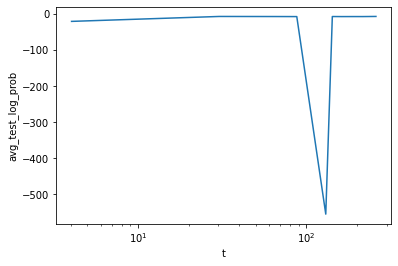

In [14]:
import seaborn as sns
output['avg_test_log_prob'] = output['avg_test_log_prob'].astype('float')
sns.lineplot(data = output, x = 't', y = 'avg_test_log_prob')
plt.xscale('log')

**3.3 HMC**

TODO: currently broken :(

In [13]:
from pyro.infer import HMC
nuts_kernel = HMC(model, step_size=0.9, num_steps=4)
num_samples = 500
mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=0,
    num_chains=1,
)

mcmc_step_ids = [0]
mcmc_average_test_log_accuracy = []
mcmc.run(torch.tensor(ff))
mcmc.summary()

Warmup:   0%|          | 1/500 [01:36, 96.31s/it, step size=1.76e-03, acc. prob=0.000]

KeyboardInterrupt: ignored